In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

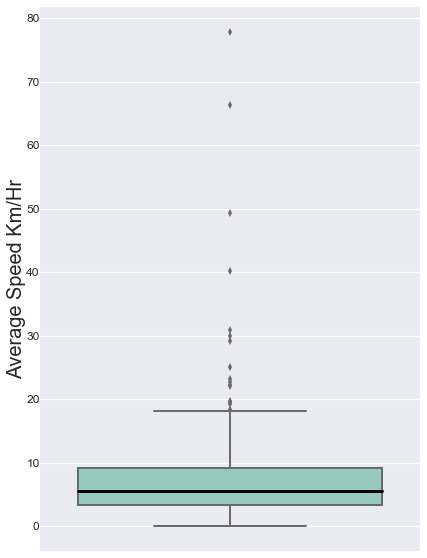

In [6]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os


# Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters


# find the first and last points from each plt files
def populate_firstlst_pts_df(file_src, user):
    global firstlst_pts_df

    #firstlst_pts_df = firstlst_pts_df.iloc[0:0]

    for dirname, dirnames, filenames in os.walk(file_src):
        i = len(firstlst_pts_df)
        for filename in filenames:
            if filename.endswith('plt'):
                gpsfile = os.path.join(dirname, filename)
                log = open(gpsfile, 'r')
                points = log.readlines()[6:]  # first 6 lines are useless

                first_point = points[0].rstrip().split(',')
                last_point = points[len(points) - 1].rstrip().split(',')
                start_time = first_point[5] + " " + first_point[6]
                end_time = last_point[5] + " " + last_point[6]
                trj_time = (datetime.strptime(end_time, time_format) - datetime.strptime(start_time,
                                                                                        time_format)) / timedelta(minutes=1)
                firstlst_pts_df.loc[i, 'User'] = user
                firstlst_pts_df.loc[i, 'File'] = filename
                firstlst_pts_df.loc[i, 'TrajId'] = i
                firstlst_pts_df.loc[i, 'Dist(km)'] = meters(float(first_point[0]), float(first_point[1]),
                                                            float(last_point[0]), float(last_point[1])) / 1000
                firstlst_pts_df.loc[i, 'Time(hr)'] = trj_time / 60
                firstlst_pts_df.loc[i, 'Spd(km/hr)'] = ((firstlst_pts_df.loc[i, 'Dist(km)']) /
                                                        (firstlst_pts_df.loc[i, 'Time(hr)']))
                i += 1


# calculate the mean of speed, distance, time for each user
def calMean(user):
    mean_speed = firstlst_pts_df.loc[(firstlst_pts_df['User'] == user), 'Spd(km/hr)'].mean()
    mean_dis = firstlst_pts_df.loc[(firstlst_pts_df['User'] == user), 'Dist(km)'].mean()
    mean_time = firstlst_pts_df.loc[(firstlst_pts_df['User'] == user), 'Time(hr)'].mean()
    return mean_speed, mean_dis, mean_time


# draw the box plot
def draw_boxplt():
    avgspeed_df['User'] = (avgspeed_df['User']).astype(int)
    avg_vals = avgspeed_df.groupby('AvgSpeed(Km/Hr)').std()

    sns.set_context("talk")

    plt.rcParams['figure.figsize'] = 15, 10
    plt.rcParams['font.weight'] = 'normal'
    plt.rcParams['font.size'] = 10
    sns.set_style("darkgrid")
    params = {'axes.labelsize': 'large',
              'axes.titlesize': 'large',
              'xtick.labelsize': 'large',
              'ytick.labelsize': 'large',
              'ytick.major.pad': '0',
              'xtick.major.pad': '10',
              'ytick.minor.pad': '0',
              'axes.labelpad': '0'}
    plt.rcParams.update(params)
    plt.rc('pdf', fonttype=42)
    plt.figure()

    ax = plt.subplot(121)
    ax = sns.boxplot(y=avgspeed_df["AvgSpeed(Km/Hr)"], data=avg_vals,
                     palette="Set3", linewidth=2, medianprops={'color': 'k', 'linewidth': 3})
    plt.ylabel("Average Speed Km/Hr", fontsize=20)


def prepare_df():
    global firstlst_pts_df
    global avgspeed_df

    firstlst_pts_df['TrajId'] = 0
    firstlst_pts_df['User'] = 0
    firstlst_pts_df['File'] = 0
    firstlst_pts_df['Dist(km)'] = 0.0
    firstlst_pts_df['Time(hr)'] = 0.0
    firstlst_pts_df['Spd(km/hr)'] = 0.0

    avgspeed_df['User'] = 0
    avgspeed_df['AvgSpeed(Km/Hr)'] = 0.0
    avgspeed_df.loc['AvgDistance(Km)'] = 0.0


# ------------------------------------------------------------
def main():
    prepare_df()

    for i in range(0, 182):
        user = "%03d" % i
        file_src = file_path + str(user) + '/Trajectory/'

        populate_firstlst_pts_df(file_src, user)
        avg_speed, avg_dis, avg_time = calMean(user)

        avgspeed_df.loc[i, 'User'] = str(user)
        avgspeed_df.loc[i, 'AvgSpeed(Km/Hr)'] = avg_speed
        avgspeed_df.loc[i, 'AvgDistance(Km)'] = avg_dis

    dest_file = destination + " avgspeed_df.csv"
    avgspeed_df.to_csv(dest_file, sep='\t', encoding='utf-8')

    draw_boxplt()
    

# ---------------------------------------------------------------
time_format = '%Y-%m-%d %H:%M:%S'
firstlst_pts_df = pd.DataFrame()
avgspeed_df = pd.DataFrame()

file_path = 'C:/Users/12sha/Documents/Geolife Trajectories 1.3/Data/'
destination = 'C:/Users/12sha/Documents/thesislocation/Data/avgspeed/'

main()